<a href="https://www.kaggle.com/code/trungdt28/dogs-cats?scriptVersionId=132610190" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from os import listdir
from numpy import asarray
from numpy import save 
import tensorflow as tf
import PIL
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import os

folder = r"/kaggle/input/dogs-vs-cats/train"
photos, labels = list(), list()

for file in listdir(folder):
    output = 0.0   
    if file.startswith("dog"):
        output = 1.0
    
    photo = load_img(os.path.join(folder ,file), target_size=(128, 128), color_mode = "rgb")
    photo = img_to_array(photo)

    photos.append(photo)
    labels.append(output)

photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)

save("dogs_vs_cats_photos.npy", photos)  
save("dogs_vs_cats_labels.npy", labels)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(25000, 128, 128, 3) (25000,)


In [2]:
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random


#create directories 
dataset_home = "dataset_dogs_vs_cats/"
subdirs = ["train/", "test/"]
for subdir in subdirs:
    labeldirs = ["dogs/", "cats/"]
    for labeldir in labeldirs:
        newdir = dataset_home + subdir + labeldir
        makedirs(newdir, exist_ok=True)

#seed generator
seed(1)

val_ratio = 0.25

src_directory = r"/kaggle/input/dogs-vs-cats/train"
for file in listdir(src_directory):
    src = src_directory + "/" + file
    dst_dir = "train/"
    if random() < val_ratio:
        dst_dir = "test/"
    if file.startswith("cat"):
        dst = dataset_home + dst_dir + "cats/" + file
        copyfile(src, dst)
    elif file.startswith("dog"):
        dst = dataset_home + dst_dir + "dogs/" + file
        copyfile(src, dst)

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from PIL import Image
import os



In [12]:
# Load the VGG16 pre-trained model
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of VGG16
for layer in vgg16.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [13]:
# Create a new model
model = keras.Sequential([
    vgg16,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [14]:
rescale_factor = 1.0 / 255.0

# Create an instance of the ImageDataGenerator with desired augmentation and rescaling options
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=rescale_factor 
)

# Create the data generators for train and validation
val_datagen = ImageDataGenerator(rescale=rescale_factor)
# Load the dataset
train_data = datagen.flow_from_directory(
    '/kaggle/working/dataset_dogs_vs_cats/train',
    target_size=(128, 128),
    batch_size=64,
    color_mode="rgb",
)

val_data = val_datagen.flow_from_directory(
    '/kaggle/working/dataset_dogs_vs_cats/train',
    target_size=(128, 128),
    batch_size=64,
    color_mode="rgb",
)

Found 18697 images belonging to 2 classes.
Found 18697 images belonging to 2 classes.


In [15]:
# Define the callbacks
checkpoint_callback = ModelCheckpoint('dog_cat_classifier_model.h5', verbose=1, save_best_only=True, monitor='val_accuracy', mode='min')
early_stop_callback = EarlyStopping(monitor='val_accuracy', patience=5)

# Train the model with callbacks
history = model.fit(train_data, validation_data=val_data, epochs=100, callbacks=[checkpoint_callback, early_stop_callback])

# Save the trained model
model.save('dog_cat_classifier_model.h5')

# Load the saved model
loaded_model = keras.models.load_model('dog_cat_classifier_model.h5')

Epoch 1/100
293/293 [==============================] - ETA: 0s - loss: 0.4040 - accuracy: 0.8210
Epoch 1: val_accuracy improved from inf to 0.88699, saving model to dog_cat_classifier_model.h5
293/293 [==============================] - 158s 533ms/step - loss: 0.4040 - accuracy: 0.8210 - val_loss: 0.2610 - val_accuracy: 0.8870
Epoch 2/100
293/293 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8518
Epoch 2: val_accuracy did not improve from 0.88699
293/293 [==============================] - 140s 480ms/step - loss: 0.3386 - accuracy: 0.8518 - val_loss: 0.2378 - val_accuracy: 0.8976
Epoch 3/100
293/293 [==============================] - ETA: 0s - loss: 0.3362 - accuracy: 0.8513
Epoch 3: val_accuracy did not improve from 0.88699
293/293 [==============================] - 141s 481ms/step - loss: 0.3362 - accuracy: 0.8513 - val_loss: 0.2367 - val_accuracy: 0.8965
Epoch 4/100
293/293 [==============================] - ETA: 0s - loss: 0.3176 - accuracy: 0.8623
Epoch 4: 

ModelCheckpoint, EarlyStop

In [16]:
# Define the test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load the test data using the generator
test_it = test_datagen.flow_from_directory(
    "/kaggle/working/dataset_dogs_vs_cats/test",
    color_mode="rgb",
    batch_size=64,
    target_size=(128, 128),
    shuffle=False  # Set shuffle to False for consistent ordering
)

Found 6303 images belonging to 2 classes.


In [17]:
# Evaluate the model on the test data
test_loss, test_accuracy = loaded_model.evaluate(test_it)

# Make predictions on the test data
predictions = loaded_model.predict(test_it)
# y_pred = np.round(predictions)
# y_true = test_it.classes

class_map = {
    v: k for k, v in test_it.class_indices.items()
}
y_pred = list(map(lambda x: class_map[x.argmax()], predictions))
y_true = list(map(lambda x: class_map[x], test_it.labels))


99/99 [==============================] - 12s 116ms/step


Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

        cats       0.93      0.87      0.90      3197
        dogs       0.88      0.93      0.91      3106

    accuracy                           0.90      6303
   macro avg       0.91      0.90      0.90      6303
weighted avg       0.91      0.90      0.90      6303

Test Accuracy: 0.9038553237915039


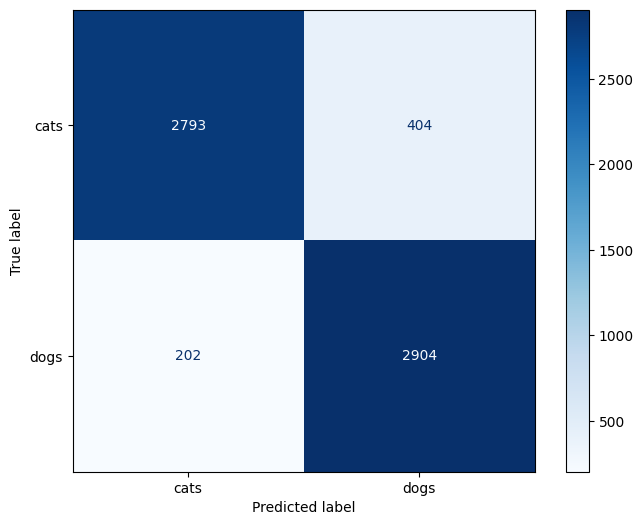

In [18]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(cm, display_labels=list(class_map.values()))
display.plot(ax=ax, cmap=plt.cm.Blues)


# Calculate precision, recall, and f1-score
report = classification_report(y_true, y_pred)

print("Confusion Matrix:")
print("\nClassification Report:")
print(report)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 1s 500ms/step


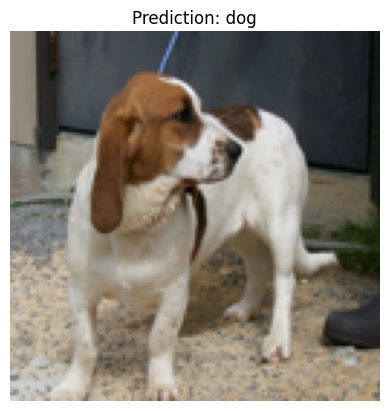

1/1 [==============================] - 0s 23ms/step


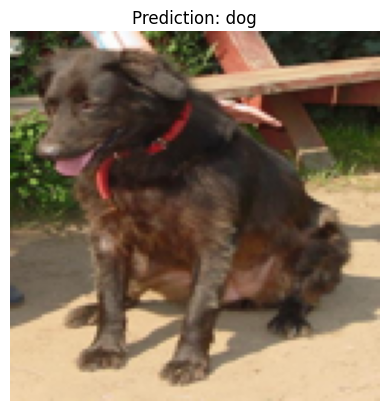

1/1 [==============================] - 0s 23ms/step


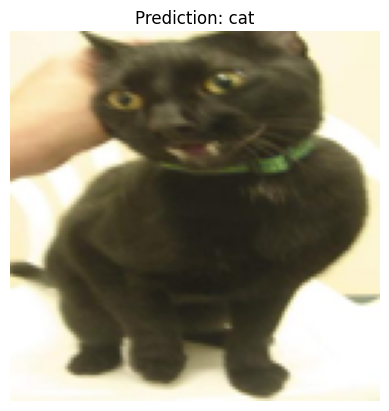

1/1 [==============================] - 0s 23ms/step


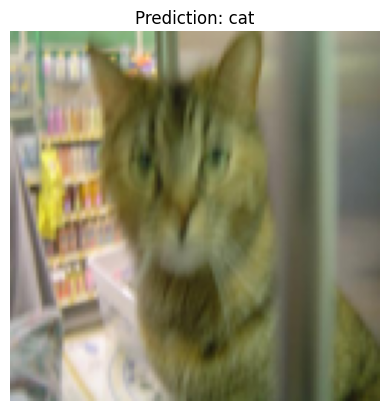

1/1 [==============================] - 0s 24ms/step


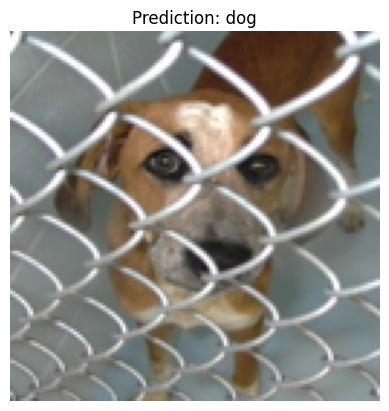

1/1 [==============================] - 0s 25ms/step


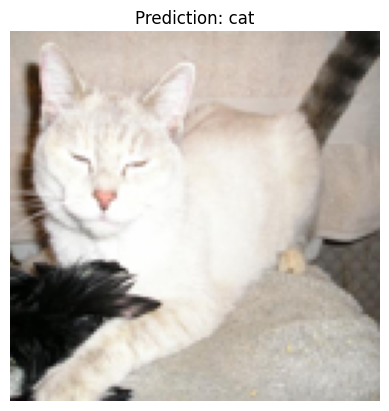

1/1 [==============================] - 0s 26ms/step


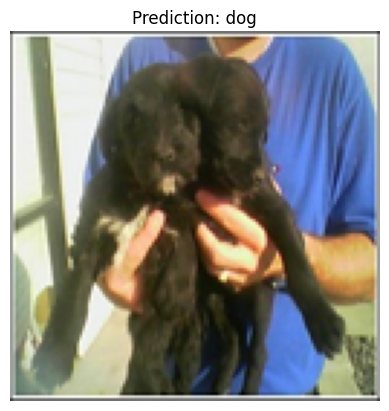

1/1 [==============================] - 0s 24ms/step


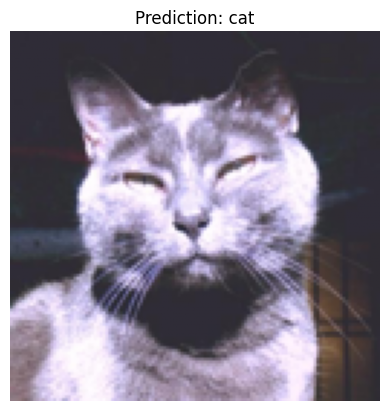

1/1 [==============================] - 0s 25ms/step


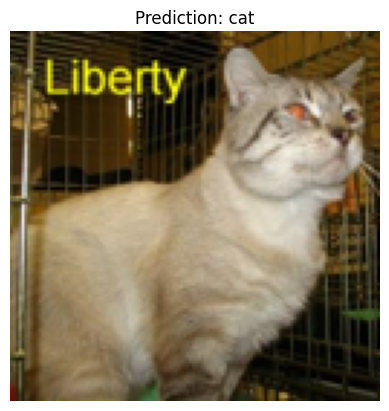

1/1 [==============================] - 0s 24ms/step


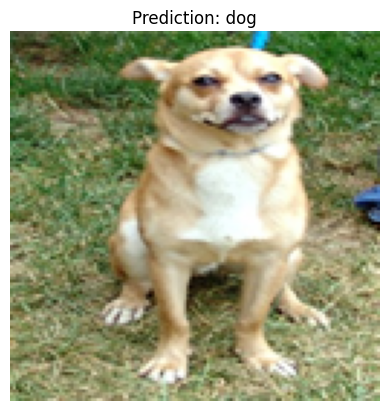

In [19]:
# Classify a new image

folder_path = "/kaggle/input/demo-pictures/demo"  
results = {0: "cat", 1: "dog"}

for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        image_path = os.path.join(folder_path, filename)
        im = Image.open(image_path)
        im = im.resize((128, 128))
        im = np.expand_dims(im, axis=0)
        im = np.array(im) / 255.0
        pred_probs = loaded_model.predict(im)[0]
        pred_class = np.argmax(pred_probs)
        prediction = results[pred_class]
        
        # Display the image and prediction result
        plt.imshow(im[0])
        plt.axis('off')
        plt.title(f"Prediction: {prediction}")
        plt.show()
